In [1]:
import numpy as np
from lloyd_utils import lloyd_update, calc_distances
from kernel_utils import kernel_matrix

In [2]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=1,
                 max_iter=300, tol=0, verbose=0,
                 seed=None, algorithm="lloyd", kernel="linear", **kwargs):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.random = np.random.default_rng(seed)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwargs = kwargs
        self.labels = None
        self.inner_sums = None
        self.trained_data = None
        self.cluster_sizes = None
        
    def _p_kernel_wrapper(self, X, Y=None):
        return kernel_matrix(X, Y, kernel=self.kernel, **self.kwargs)
    
    def fit(self, X):
        ''' Provides interface for user to fit data.'''
        self._check_data(X)
        
        if self.algorithm == "lloyd":
            self._lloyd(X)

        self.trained_data = X
        
    def _check_data(self, X):
        return
    
    def _lloyd(self, X):
        '''
        The original kkmeans algorithm.
        _init is used to assign labels.
        inertia is sum of squared distances to nearest centroid (==variance).
        each row of distances is datapoint, each column centroid,
            e.g. distances[0,0] is distance from data[0] to center of first cluster.
        From mathematical pov distances could be initialized with 0-matrix each iter,
            but too little time is saved to justify the risk of confusion,
            as the resulting inertia wouldn't be variance anymore (but still as valid)
        _lloyd_iter updates distances from each point to each centroid, by using 
            formulas from kkmeans paper.
        
        '''
        self.inner_sums = np.zeros((len(X), self.n_clusters))
        kernel_matrix = self._p_kernel_wrapper(X)
        self._init(X, kernel_matrix) #CALL THIS NOT IN LLOYD! 
        inertia = 0
        for _ in range(self.max_iter):
            distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T
            distances, self.inner_sums, self.cluster_sizes =\
                    lloyd_update(distances, kernel_matrix, self.labels, self.n_clusters)
            lables_old = self.labels
            self.labels = np.argmin(distances, axis=1)
            inertia_old = inertia
            inertia = np.amin(distances, axis=1).sum() 
            if all(lables_old == self.labels) or abs(inertia - inertia_old) < self.tol:
                if self.verbose:
                    print("Converged at iteration:", _ + 1,
                          "Inertia:", inertia)
                return

    
    def _init(self, X, kernel_matrix): # TODO RENAME!!
        '''Assign labels to each datapoint by given method'''
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self._check_centroids() # TODO 
            self._assign_to_centroids(self.init, X)
            return
        
        elif self.init == "random":
            centroids = X[self.random.integers(0, len(X), self.n_clusters)]
            self.labels = self._assign_to_centroids(centroids, X)
            return
        
        elif self.init == "truerandom":
            self.labels = self.random.integers(0, self.n_clusters, len(X))
            return
        
        elif self.init == "kmeans++":
            self.labels = self._kmeanspp(X, kernel_matrix)
            return 
        
        raise Exception("Unknown initialisation method")
    
    def _check_centroids(self):
        if len(self.init) != self.n_clusters:
            raise Exception("The number of given centroids should match n_clusters") # TODO
        return

    def _assign_to_centroids(self, centroids, X):
        '''
        Calculates distances to each given center by using SQUARED distances,
        as in the feature space one cannot explicitly calculate euclidian distance
        and instead one has to rely on ||a-b||^2 == K(a,a) - 2K(a,b) + K(b,b)
        (K(.,.) is the kernel)
        (Here, K(a,a) is omitted since it is doesn't change for each datapoint)
        '''
        data_centr_kernel = self._p_kernel_wrapper(X, centroids)
        centr_distances = np.zeros((len(X), self.n_clusters))
        for cluster in range(self.n_clusters):
            centr_distances[:, cluster] = (-2 * data_centr_kernel[:, cluster]
                                        + self._p_kernel_wrapper([centroids[cluster]]))
        return np.argmin(centr_distances, axis = 1)

    
    def _kmeanspp(self, X, kernel_matrix):
        '''
        Kmeans++ with the distance described in _assign_to_centroids.
        Here, K(a,a) must NOT be omitted.
        '''
        centroids = np.zeros((self.n_clusters, len(X[0])))
        centr_distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T   
        for cluster in range(self.n_clusters):
            if cluster == 0:
                #random first center
                index = self.random.integers(low=0, high=len(X))
            else:
                max_dist_each = np.amin(centr_distances[:, :cluster + 1], axis = 1)
                max_dist_each[max_dist_each < 0] = 0 
                probs = max_dist_each/max_dist_each.sum()
                index = self.random.choice(len(X), size=1, p=probs)
            centroids[cluster] = X[index]
            cluster_term = self._p_kernel_wrapper([centroids[cluster]])
            data_term = self._p_kernel_wrapper(X, [centroids[cluster]])
            centr_distances[:, cluster] += (-2 * data_term + cluster_term).reshape(len(X),)    
        return np.argmin(centr_distances, axis=1)                
            
    def predict(self, X):
        kernel_matrix = self._p_kernel_wrapper(X, self.trained_data)
        distances = calc_distances(self.inner_sums, 
                                  self.cluster_sizes,
                                  kernel_matrix,
                                  self.labels, 
                                  self.n_clusters)
        return np.argmin(distances, axis=1)
            
            


In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [4]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [5]:
x, labels, centers = make_blobs(20000, centers = 2, return_centers = True, random_state = 0, n_features = 2)

In [6]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "linear", seed = 0, tol = 1e-4)

Converged at iteration: 7 Inertia: 37754.17389319425
1.777683973312378


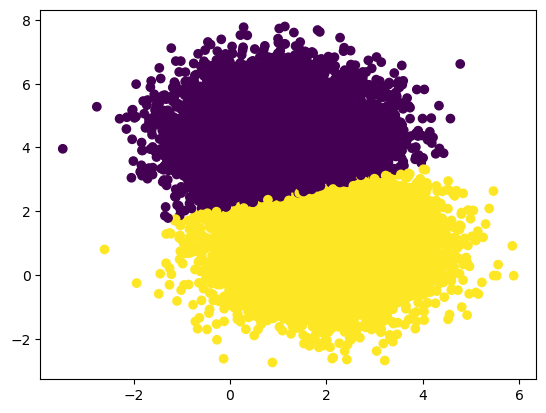

In [7]:
import time as t
start = t.time()
kkm.fit(x)
print(t.time() - start)
visualize(x, kkm.labels)

In [13]:
x, l = make_circles(5000, factor = 0.4, random_state=0)

In [14]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "rbf", seed = 0, tol = 1e-4, variance=0.1)

Converged at iteration: 101 Inertia: 4752.421626849112
1.293341875076294


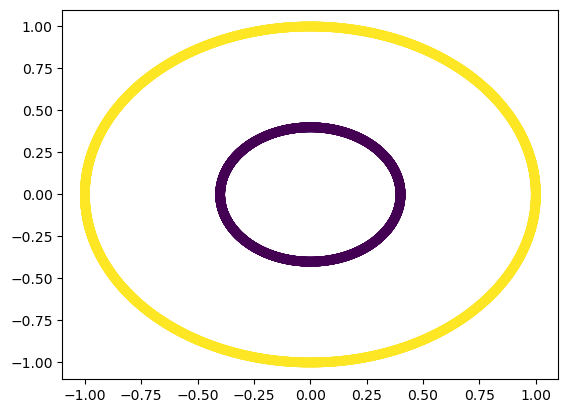

In [15]:
import time as t
start = t.time()
kkm.fit(x)
print(t.time() - start)
visualize(x, kkm.labels)

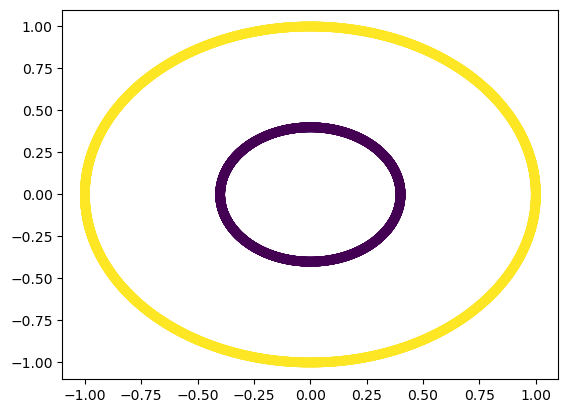

In [12]:
visualize(x, kkm.predict(x))

In [12]:
all(kkm.predict(x) == kkm.labels)

True

In [14]:
from sklearn.cluster import KMeans

In [18]:
km = KMeans(n_clusters=2)

In [22]:
km.fit(x)

KMeans(n_clusters=2)

In [23]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` observations (rows) at random from data
 |      for the i

In [11]:
from sklearn.metrics.pairwise import pairwise_kernels
from time import time

In [12]:
t = time()
pairwise_kernels(x)
e = time()
print(e-t)

1.694709062576294
